In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import cv2
# import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import gc
import warnings
warnings.filterwarnings("ignore")

import random
# import torch
# import torch.nn as nn
import albumentations

# import segmentation_models_pytorch as smp
import skimage


from tqdm import tqdm
# import torch.optim as optim
# from torch.utils.data import TensorDataset, DataLoader,Dataset
# from fastprogress import master_bar, progress_bar

def create_dir(path):
    if os.path.isdir(path)==False:
        os.makedirs(path)

In [ ]:
from pathlib import Path
PROJ_DIRECTORY = Path.cwd()

In [2]:
# set pose estimation training data path
data_path= str(PROJ_DIRECTORY / 'datasets' / 'pose') + "/"

In [3]:
from ultralytics import YOLO
# load trained Yolo
model = YOLO( PROJ_DIRECTORY / 'finetune/train/weights/last.pt')
# model = YOLO('last_used.pt')

In [4]:
# read the .csv files, set the right path
train_labels=pd.read_csv(data_path + 'train_labels.csv')
rangeDF=pd.read_csv(data_path + 'range.csv')
train_labels.shape, rangeDF.shape

((66000, 9), (66000, 3))

In [5]:
NUM_TARGETS=1
CENTER_CROP=384
RESIZE=384

In [6]:
s=train_labels.loc[train_labels.chain_id=='0036465cc6',:]
s.head()

,chain_id,i,x,y,z,qw,qx,qy,qz
0,0036465cc6,0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
1,0036465cc6,1,0.571732,8.856913,-11.087827,0.996956,-0.046685,-0.046640,-0.041523
2,0036465cc6,2,-0.014641,2.789255,-5.214775,0.988523,-0.149369,-0.017915,-0.013805
3,0036465cc6,3,0.585297,-3.229511,6.535775,0.967863,-0.249140,0.025555,0.022740
4,0036465cc6,4,0.001839,-5.679097,-0.621195,0.927903,-0.371874,-0.009899,0.024641


In [7]:
img=cv2.imread(data_path / 'images/0036465cc6/000.png')
img.shape

(1024, 1280, 3)

In [8]:
np.mean(img,(0,1))

array([    0.50849,     0.52079,     0.52299])

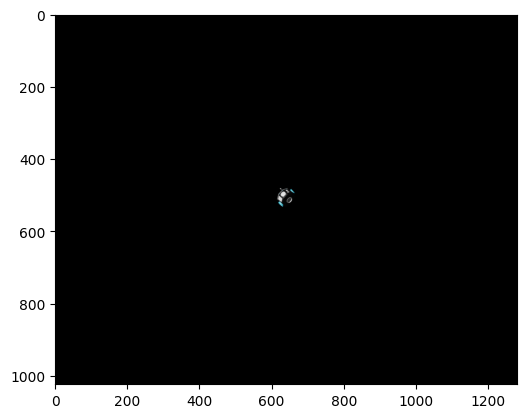

In [9]:
plt.imshow(img)
plt.show()

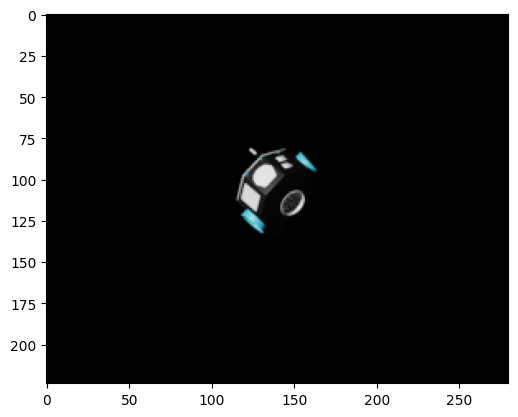

In [10]:
plt.imshow(img[400:-400,500:-500,:])
plt.show()

In [11]:
cases = os.listdir(data_path+'images')
len(cases)

621

In [12]:
a=(os.listdir(data_path+'images/'+cases[0]))
a.sort()
# print(a)

In [13]:
np.unique([len(os.listdir(data_path+'images/'+x)) for x in cases],return_counts=True)

(array([ 83, 100]), array([  1, 620]))

In [14]:
np.where(np.array([len(os.listdir(data_path+'images/'+x)) for x in cases])==83)

(array([492]),)

In [15]:
cases[492]

'c7b8e6149d'

In [16]:
len(os.listdir(data_path+'images/'+cases[492]))

83

In [17]:
os.listdir(data_path+'images/'+cases[0])[:5]

['082.png', '097.png', '084.png', '023.png', '017.png']

In [18]:
# train-val split 80-20
np.random.seed(42)
val_cases=np.random.choice(cases,int(0.2*(len(cases))), replace=False)
train_cases=np.array([x for x in cases if x not in val_cases])
len(val_cases),len(np.unique(val_cases)),len(train_cases)

(124, 124, 497)

In [19]:
[x for x in train_cases if x in [cases[492]]]

['c7b8e6149d']

In [20]:
val_ids=[]
val_targets=[]
for c in tqdm(val_cases):
    p=data_path+'images/'+c+'/'
    all_images=os.listdir(p)
    all_images=[x for x in all_images if x not in ['000.png']]
    for im in all_images:
        val_ids.append([p+'000.png', p+im])
        val_targets.append(train_labels.loc[(train_labels.chain_id==c)&(train_labels.i==int(im.split('.')[0])),
                                                                    ['x','y','z','qw','qx','qy','qz'] ].values)

val_ids=np.vstack(val_ids)
val_targets=np.vstack(val_targets)
len(val_ids),val_targets.shape

100%|██████████| 124/124 [01:32<00:00,  1.35it/s]


(12276, (12276, 7))

In [21]:
val_chains=[x[1].split('/')[-2] for x in val_ids]
val_chains_i=[int(x[1].split('/')[-1][:-4]) for x in val_ids]
ref=pd.DataFrame({'chain_id': np.unique(val_chains)})
ref['i']=0
ref['x']=0
ref['y']=0
ref['z']=0
ref['qw']=1
ref['qx']=0
ref['qy']=0
ref['qz']=0
# train_labels

# val_chain_gt_df = pd.DataFrame(np.concatenate((np.expand_dims(val_chains,-1), np.expand_dims(val_chains_i,-1), val_targets),-1))
# val_chain_gt_df.columns=train_labels.columns
# val_chain_gt_df.iloc[:,1:]=val_chain_gt_df.iloc[:,1:].astype(float)
# val_chain_gt_df = pd.concat([val_chain_gt_df, ref]).sort_values(['chain_id','i']).reset_index(drop=True)
# val_chain_gt_df.to_csv('val_chain_gt_df.csv',index=False)
# val_chain_gt_df
# # train_labels

In [22]:
train_ids=[]
train_targets=[]
for c in tqdm(train_cases):
    p=data_path+'images/'+c+'/'
    if os.path.isdir(p):
        all_images=os.listdir(p)
        all_images=[x for x in all_images if x not in ['000.png']]
        for im in all_images:
            train_ids.append([p+'000.png', p+im])
            train_targets.append(train_labels.loc[(train_labels.chain_id==c)&(train_labels.i==int(im.split('.')[0])),
                                                                        ['x','y','z','qw','qx','qy','qz'] ].values)

train_ids=np.vstack(train_ids)
train_targets=np.vstack(train_targets)
len(train_ids),train_targets.shape


100%|██████████| 497/497 [06:08<00:00,  1.35it/s]


(49186, (49186, 7))

In [29]:
# train_shapes=[]
# failed_reading=[]
# for c in tqdm(train_cases):
#     p=data_path+'images/'+c+'/'
#     all_images=os.listdir(p)
# #     all_images=[x for x in all_images if x not in ['000.png']]
#     for im in all_images:
#         try:
#             img = cv2.imread(p+im)
#             train_shapes.append( [p+im, img.shape])
#         except:
#             failed_reading.append( p+im)

# # np.unique(np.vstack(train_shapes)[:,1])
# # array([(1024, 1280, 3)], dtype=object)
# # failed_reading
# # ['/fast/Spacecraft_Pose_Estimation/images/c7b8e6149d/005.png']

In [30]:
# val_shapes=[]
# val_failed_reading=[]
# for c in tqdm(val_cases):
#     p=data_path+'images/'+c+'/'
#     all_images=os.listdir(p)
# #     all_images=[x for x in all_images if x not in ['000.png']]
#     for im in all_images:
#         try:
#             img = cv2.imread(p+im)
#             val_shapes.append( [p+im, img.shape])
#         except:
#             val_failed_reading.append( p+im)
# # (array([(1024, 1280, 3)], dtype=object),
# #  ['/fast/Spacecraft_Pose_Estimation/images/898466710c/059.png',
# #   '/fast/Spacecraft_Pose_Estimation/images/575ebc7410/040.png',
# #   '/fast/Spacecraft_Pose_Estimation/images/af0973ade8/059.png'])
# # for n in val_failed_reading:
# #     print(np.where(val_ids[:,1]==n)[0][0])
# # 856
# # 1285
# # 1747


In [31]:
# for n in val_failed_reading:
#     print(np.where(val_ids[:,1]==n)[0][0])

In [48]:
# train_ids[39186],val_ids[[856, 1285, 1747],:]

In [36]:
removethisids=np.array([[data_path + 'images/c7b8e6149d/000.png', data_path + 'images/c7b8e6149d/005.png'],

        [data_path + 'images/898466710c/000.png', data_path + 'images/898466710c/059.png'],
        [data_path + 'images/575ebc7410/000.png', data_path + 'images/575ebc7410/040.png'],
        [data_path + 'images/af0973ade8/000.png', data_path + 'images/af0973ade8/059.png']])
removethisids.shape

(4, 2)

In [47]:
remove_inds_from_train = []
for i in range(len(removethisids)):
    try:
        remove_inds_from_train.append(np.where(train_ids[:,1]==removethisids[i][1])[0][0])
    except:
        pass
remove_inds_from_val = []
for i in range(len(removethisids)):
    try:
        remove_inds_from_val.append(np.where(val_ids[:,1]==removethisids[i][1])[0][0])
    except:
        pass
remove_inds_from_train, remove_inds_from_val

([39186], [856, 1285, 1747])

In [49]:
if len(remove_inds_from_train)>0:
    train_ids=train_ids[[x for x in range(len(train_ids)) if x not in remove_inds_from_train],:]
    train_targets=train_targets[[x for x in range(len(train_targets)) if x not in remove_inds_from_train],:]

if len(remove_inds_from_val)>0:
    val_ids=val_ids[[x for x in range(len(val_ids)) if x not in remove_inds_from_val],:]
    val_targets=val_targets[[x for x in range(len(val_targets)) if x not in remove_inds_from_val],:]


train_ids.shape, train_targets.shape, val_ids.shape, val_targets.shape

((49185, 2), (49185, 7), (12273, 2), (12273, 7))

In [32]:
# train_ids=train_ids[[x for x in range(len(train_ids)) if x not in [39186]],:]
# train_targets=train_targets[[x for x in range(len(train_targets)) if x not in [39186]],:]

# val_ids=val_ids[[x for x in range(len(val_ids)) if x not in [856, 1285, 1747]],:]
# val_targets=val_targets[[x for x in range(len(val_targets)) if x not in [856, 1285, 1747]],:]


# train_ids.shape, train_targets.shape, val_ids.shape, val_targets.shape

((49185, 2), (49185, 7), (12273, 2), (12273, 7))

In [50]:
if len(remove_inds_from_val)>0:
    val_chains=np.array(val_chains)[[x for x in range(len(val_chains)) if x not in remove_inds_from_val]]
    val_chains_i=np.array(val_chains_i)[[x for x in range(len(val_chains_i)) if x not in remove_inds_from_val]]
len(val_chains_i),len(val_chains)

(12273, 12273)

In [33]:
# val_chains=np.array(val_chains)[[x for x in range(len(val_chains)) if x not in [856, 1285, 1747]]]
# val_chains_i=np.array(val_chains_i)[[x for x in range(len(val_chains_i)) if x not in [856, 1285, 1747]]]
# len(val_chains_i),len(val_chains)

(12273, 12273)

In [51]:
val_chain_gt_df = pd.DataFrame(np.concatenate((np.expand_dims(val_chains,-1), np.expand_dims(val_chains_i,-1), val_targets),-1))
val_chain_gt_df.columns=train_labels.columns
val_chain_gt_df.iloc[:,1:]=val_chain_gt_df.iloc[:,1:].astype(float)
val_chain_gt_df = pd.concat([val_chain_gt_df, ref]).sort_values(['chain_id','i']).reset_index(drop=True)
val_chain_gt_df.to_csv('val_chain_gt_df.csv',index=False)
val_chain_gt_df
# train_labels

,chain_id,i,x,y,z,qw,qx,qy,qz
0,031dbad3c0,0,0,0,0,1,0,0,0
1,031dbad3c0,1.0,12.114075,-78.491692,-11.749588,0.990646,0.040924,-0.013321,0.129492
2,031dbad3c0,2.0,7.685059,-65.040146,-11.8153,0.993682,0.037831,-0.012172,0.104963
3,031dbad3c0,3.0,17.884277,-97.27285,-10.788047,0.985571,0.048023,-0.016243,0.161491
4,031dbad3c0,4.0,6.934784,-54.452129,-8.48818,0.991626,0.094688,-0.003965,0.087727
...,...,...,...,...,...,...,...,...,...
12392,fe8bbecd83,95.0,35.061722,9.433044,-131.909546,0.966501,0.024006,-0.254768,-0.019803
12393,fe8bbecd83,96.0,45.657578,25.128151,-145.975113,0.955316,0.052766,-0.287164,-0.046076
12394,fe8bbecd83,97.0,40.431274,-11.17926,-141.36113,0.952461,0.140735,-0.265455,0.050442
12395,fe8bbecd83,98.0,42.742828,-7.558107,-143.729889,0.949211,0.152283,-0.271309,0.046901


In [52]:
# train_labels

In [53]:
def center_crop(img, final_size=CENTER_CROP):
    y, x = img.shape[:2]
    y2 = max(0, int(y/2-final_size/2))
    x2 = max(0, int(x/2-final_size/2))
#     print(y2,x2)
    return img[y2:-y2,x2:-x2,:]
img.shape, center_crop(img).shape

((1024, 1280, 3), (384, 384, 3))

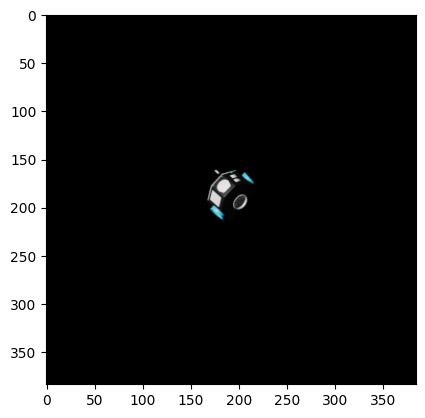

In [54]:
plt.imshow(center_crop(img))
plt.show()

In [55]:
def np_log_with_sign(ar):
    signs = np.sign(ar)
    return np.log(np.abs(ar))*signs

In [56]:
# results = model('/fast/Spacecraft_Pose_Estimation/images/024e86dc87/000.png')
results = model.predict(data_path + 'images/024e86dc87/000.png')#, verbose=False



image 1/1 /fast/Spacecraft_Pose_Estimation/images/024e86dc87/000.png: 512x640 1 spacecraft0, 21.1ms
Speed: 29.2ms preprocess, 21.1ms inference, 424.5ms postprocess per image at shape (1, 3, 512, 640)


In [57]:
# onnx_model = YOLO('best.onnx')
# results = onnx_model('/fast/Spacecraft_Pose_Estimation/images/024e86dc87/000.png')

In [61]:
for result in results:
    for box in result.boxes:
        print(box)
        left, top, right, bottom = np.array(box.xyxy.cpu(), dtype=np.int64).squeeze()
        width = right - left
        height = bottom - top
        center = (left + int((right-left)/2), top + int((bottom-top)/2))

        print(center)

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0.], device='cuda:0')
conf: tensor([0.5788], device='cuda:0')
data: tensor([[4.0716e+02, 4.3764e+02, 8.9701e+02, 5.5791e+02, 5.7884e-01, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (1024, 1280)
shape: torch.Size([1, 6])
xywh: tensor([[652.0836, 497.7752, 489.8571, 120.2764]], device='cuda:0')
xywhn: tensor([[0.5094, 0.4861, 0.3827, 0.1175]], device='cuda:0')
xyxy: tensor([[407.1550, 437.6370, 897.0121, 557.9134]], device='cuda:0')
xyxyn: tensor([[0.3181, 0.4274, 0.7008, 0.5448]], device='cuda:0')
(652, 497)


In [62]:
print(center)

(652, 497)


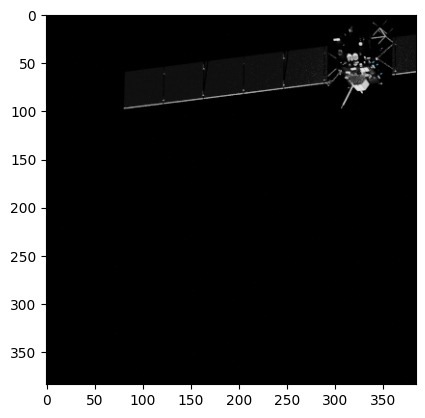

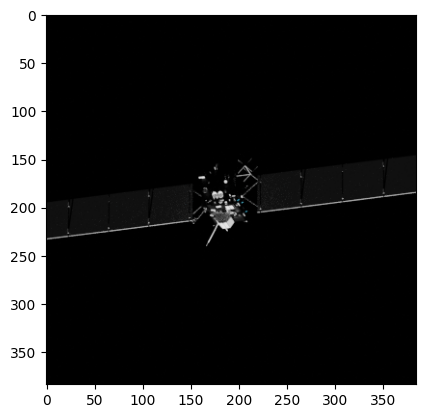

In [63]:
def sat_center_crop(img, center=(512, 640), SIZE=384):
    y, x = img.shape[:2]
    halfS=int(SIZE/2)
    y1 = max(0, center[1]-halfS)
    y2 = min(y, max(384, center[1]+halfS))
    x1 = max(0, center[0]-halfS)
    x2 = min(x, max(384, center[0]+halfS))
#     print(y2,x2)
    return img[y1:y2,x1:x2,:]
img=cv2.imread(data_path+'images/024e86dc87/000.png')
plt.imshow(sat_center_crop(img))
plt.show()
plt.imshow(sat_center_crop(img, center=center))
plt.show()

In [64]:
sat_center_val = {}
for ids in tqdm(val_ids):
    for i in range(2):
        impath=ids[i]
        if impath not in sat_center_val:
            try:
                results = model(impath, verbose=False)

                for result in results:
                    for box in result.boxes:
                        # print(box)
                        left, top, right, bottom = np.array(box.xyxy.cpu(), dtype=np.int64).squeeze()
                        width = right - left
                        height = bottom - top
                        center = (left + int((right-left)/2), top + int((bottom-top)/2))
                        # print(center)
                        sat_center_val[impath]=center
            except:
                sat_center_val[impath]=(640, 512)

100%|██████████| 12273/12273 [11:22<00:00, 17.98it/s]


In [72]:
len(sat_center_val)

12135

In [73]:
df=pd.DataFrame(sat_center_val).T.reset_index()
df.columns=['path','centerW','centerH']
df.to_csv('sat_center_val0.csv',index=False)
df

,path,centerW,centerH
0,/fast/Spacecraft_Pose_Estimation/images/1f5cc5...,729,525
1,/fast/Spacecraft_Pose_Estimation/images/1f5cc5...,629,498
2,/fast/Spacecraft_Pose_Estimation/images/1f5cc5...,573,514
3,/fast/Spacecraft_Pose_Estimation/images/1f5cc5...,772,507
4,/fast/Spacecraft_Pose_Estimation/images/1f5cc5...,650,498
...,...,...,...
12130,/fast/Spacecraft_Pose_Estimation/images/409fa6...,599,500
12131,/fast/Spacecraft_Pose_Estimation/images/409fa6...,649,508
12132,/fast/Spacecraft_Pose_Estimation/images/409fa6...,657,510
12133,/fast/Spacecraft_Pose_Estimation/images/409fa6...,632,547


In [74]:
sat_center_train = {}
for ids in tqdm(train_ids):
    for i in range(2):
        impath=ids[i]
        if impath not in sat_center_train:
            try:
                results = model(impath, verbose=False)

                for result in results:
                    for box in result.boxes:
                        # print(box)
                        left, top, right, bottom = np.array(box.xyxy.cpu(), dtype=np.int64).squeeze()
                        width = right - left
                        height = bottom - top
                        center = (left + int((right-left)/2), top + int((bottom-top)/2))
                        # print(center)
                        sat_center_train[impath]=center
            except:
                sat_center_train[impath]=(640, 512)

100%|██████████| 49185/49185 [46:19<00:00, 17.70it/s]  


In [75]:
trdf=pd.DataFrame(sat_center_train).T.reset_index()
trdf.columns=['path','centerW','centerH']
trdf.to_csv('sat_center_train0.csv',index=False)
trdf

,path,centerW,centerH
0,/fast/Spacecraft_Pose_Estimation/images/024e86...,652,497
1,/fast/Spacecraft_Pose_Estimation/images/024e86...,615,517
2,/fast/Spacecraft_Pose_Estimation/images/024e86...,620,520
3,/fast/Spacecraft_Pose_Estimation/images/024e86...,616,484
4,/fast/Spacecraft_Pose_Estimation/images/024e86...,630,500
...,...,...,...
48464,/fast/Spacecraft_Pose_Estimation/images/ff8c03...,606,477
48465,/fast/Spacecraft_Pose_Estimation/images/ff8c03...,638,525
48466,/fast/Spacecraft_Pose_Estimation/images/ff8c03...,640,506
48467,/fast/Spacecraft_Pose_Estimation/images/ff8c03...,686,515
